In [50]:
%pylab inline
import numpy as np
import cPickle as pickle
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


/Users/shivaram/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [51]:
current_palette = sns.color_palette()
read_color = current_palette[0]
write_color = current_palette[1]

In [ ]:
# python examples/s3_shuffle_benchmark.py shuffle --bucket_name=shivaram-pywren-test --mb_per_file=10 --workers=100

In [58]:
runtime_bins = np.linspace(0, 150, 150)
    
def compute_times_rates(d, start_col, tzero):
    
    x = np.array(d)
    start_time = x[:, start_col] - tzero
    end_time = x[:, start_col + 1]  - tzero
    rate = x[:, start_col + 2]

    N = len(start_time)

    runtime_rate_hist = np.zeros((N, len(runtime_bins)))
    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    for i in range(N):
        s = start_time[i]
        e = end_time[i]
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_rate_hist[i, a:b] = rate[i]
            runtime_jobs_hist[i, a:b] = 1

    return {'start_time' : start_time, 
            'end_time' : end_time, 
            'rate' : rate, 
            'runtime_rate_hist' : runtime_rate_hist, 
            'runtime_jobs_hist' : runtime_jobs_hist}

shuffle_data = pickle.load(open("/Users/shivaram/debian-shared/pywren/s3_benchmark.shuffle.output.pickle", 'r'))
x = np.array(shuffle_data)
tzero = np.min(x[:, :2])
shuffle_write  = compute_times_rates(shuffle_data, 0, tzero)
shuffle_read  = compute_times_rates(shuffle_data, 3, tzero)

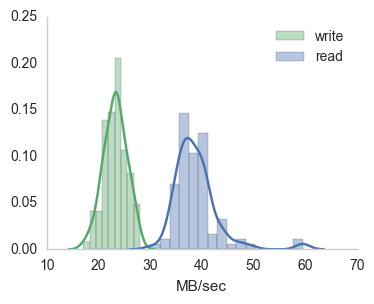

In [59]:
fig = pylab.figure(figsize=(4, 3))
sns.distplot(shuffle_write['rate'], label='write', color=write_color)
sns.distplot(shuffle_read['rate'], label='read', color=read_color)
pylab.legend()
pylab.xlabel("MB/sec")
pylab.grid(False)
sns.despine()


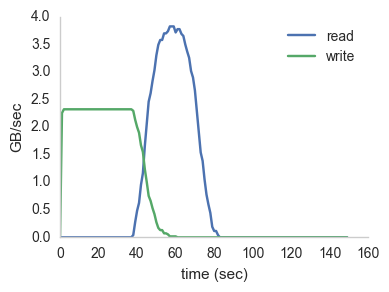

In [60]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
for d, l, c in [(shuffle_read, 'read', read_color), (shuffle_write, 'write', write_color)]:
    
    ax.plot(d['runtime_rate_hist'].sum(axis=0)/1000, label=l, c=c)
ax.set_xlabel('time (sec)')
ax.set_ylabel("GB/sec")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()

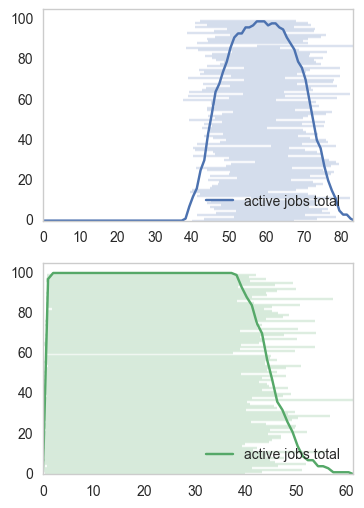

In [61]:
from matplotlib.collections import LineCollection

    
fig = pylab.figure(figsize=(4, 6))

for plot_i, (datum, l, c) in enumerate([(shuffle_read, 'read', read_color), 
                                    (shuffle_write, 'write', write_color)]):
    ax = fig.add_subplot(2, 1, 1 + plot_i)

    N = len(datum['start_time'])
    line_segments = LineCollection([[[datum['start_time'][i], i], 
                                     [datum['end_time'][i], i]] for i in range(N)],
                                   linestyles='solid', color=c, alpha=0.2)
    #line_segments.set_array(x)

    ax.add_collection(line_segments)

    ax.plot(runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), c=c, label='active jobs total')


    ax.set_xlim(0, np.max(datum['end_time']))
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    ax.grid(False)
    ax.legend(loc='lower right')